In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../bin')
from utils import load_corr_list
from cov_utils import get_EZmocks_covariance

from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG'
region = 'GCcomb'
zrange = (1.1, 1.6)

# mocks/version
version = 'v4_1'
imocks = range(25)

# multipoles
ells = (0, 2, 4)

# cut
rpcut = 0.
thetacut = 0.05

fn = DESIFileName()
fn.set_default_config(version=version, ftype='allcounts', tracer=tracer, region=region, baseline=False, weighting='_default_FKP_lin', nran=10, njack=0, split=20)

## Plots

In [3]:
## EZmock covariance
sep, cov = get_EZmocks_covariance(stat='xi', tracer=tracer, region=region, zrange=zrange, completeness='ffa', ells=ells, thetacut=thetacut, select=(0, 200, 4), return_x=True)

In [4]:
std = np.sqrt(np.diag(np.abs(cov))).reshape((len(ells), len(cov)//len(ells)))

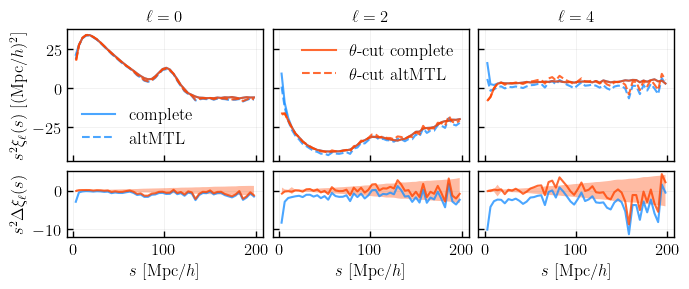

In [5]:
plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(2, 3, figsize=(7, 3), sharey='row', sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for c, cut in zip(['C0', 'C1'], [0., max(rpcut, thetacut)]):
    fn.set_default_config(completeness=False, version=version).update(zrange=zrange)
    poles = load_corr_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=4)
    #fn.set_default_config(completeness='ffa', version=version).update(zrange=zrange)
    #poles_ffa = load_corr_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=4)
    fn.set_default_config(completeness=True, version=version).update(zrange=zrange)
    poles_complete = load_corr_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=4)
    for i, ell in enumerate(ells):
        axes[0][i].plot(poles_complete['sep'][i], poles_complete['sep'][i]**2 * poles_complete['data'][i], color=c, ls='-', alpha=0.8)
        axes[0][i].plot(poles['sep'][i], poles['sep'][i]**2 * poles['data'][i], color=c, ls='--', alpha=0.8)
        axes[1][i].plot(poles['sep'][i], poles['sep'][i]**2 * (poles['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8)
        #axes[1][i].plot(poles['sep'][i], poles['sep'][i]**2 * (poles_ffa['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8, ls=':', label='ffa' if (i==1) & (c=='C0') else '')
        axes[1][i].fill_between(sep, -sep**2 * std[i]/5, sep**2 * std[i]/5, facecolor='C1', alpha=0.2)
        #axes[1][i].fill_between(poles['sep'][i], -poles['sep'][i]**2 * poles['std'][i]/5, poles['sep'][i]**2 * poles['std'][i]/5, facecolor='lightgrey', alpha=0.2)
axes[0][0].set_ylabel(r'$s^2 \xi_\ell (s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_\ell (s)$')

for i, ell in enumerate(ells):
    axes[1][i].set_xlabel('$s$ [Mpc/$h$]')  
    axes[0][i].set_title(r'$\ell={}$'.format(ell))
axes[0][0].plot([], [], ls='-', label='complete', color='C0', alpha=0.8)
axes[0][0].plot([], [], ls='--', label='altMTL', color='C0', alpha=0.8)
if rpcut:
    axes[0][1].plot([], [], ls='-', label='cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='C1', alpha=0.8)
if thetacut:
    axes[0][1].plot([], [], ls='-', label=r'$\theta$-cut complete', color='C1', alpha=0.8)
    axes[0][1].plot([], [], ls='--', label=r'$\theta$-cut altMTL', color='C1', alpha=0.8)

axes[0][0].legend()
axes[0][1].legend()
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'corr_altmtl_{}cut{}_{}_{}_z{:.1f}-{:.1f}_{}mocks.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], len(imocks))), dpi=200)
plt.show()